#Imports

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Helper functions

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def predict(model, data):
    model.eval()
    prediction = []
    with torch.no_grad():
        for x_batch, y_batch in data:
            pred = model(x_batch).numpy()
            prediction.append(pred)
    prediction = np.array(prediction)
    prediction = np.concatenate(prediction)
    return prediction

def train(model, loss_fn, optimizer, num_epochs, train_loader, data_loader):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_val_loss = 0

        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_loader)
        train_losses.append(avg_train_loss)

        if epoch % 50 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                avg_val_loss += loss.item() / len(val_loader)
            val_losses.append(avg_val_loss)
    plt.plot(train_losses, label = 'train loss')
    plt.plot(val_losses, label = 'val loss')
    plt.title("Графики лоссов")
    plt.legend()

def print_metrics(test, prediction):
    print(f'MAE: {mean_absolute_error(test, prediction)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(test, prediction))}')

#Data

Ежемесячные данные о количестве пассажиров, перевезенных одной американской авиакомпанией с 1949 по 1960 годы

In [ ]:
passengers = pd.read_csv("/content/passengers.csv", index_col = 'Month', parse_dates = True)
passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


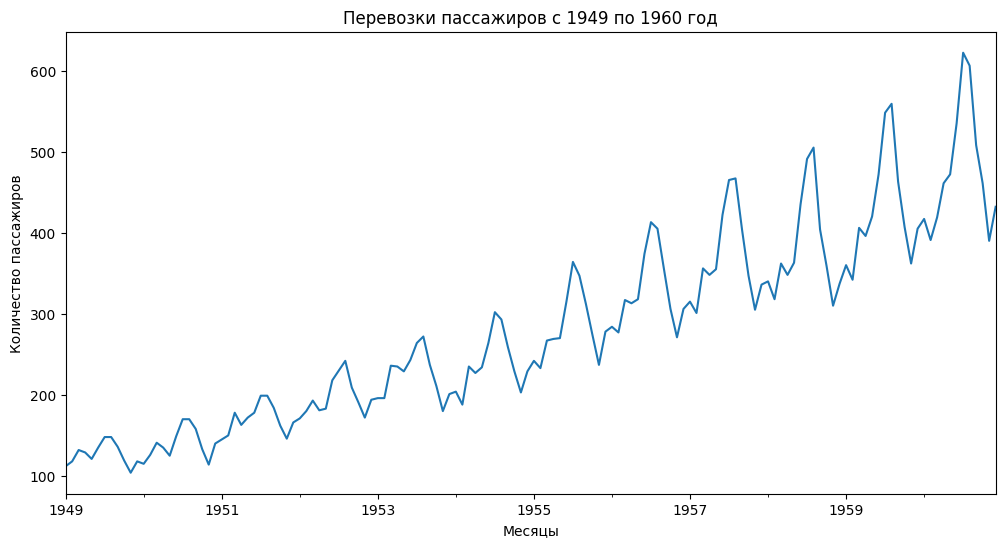

In [ ]:
ax = passengers.plot(figsize = (12,6), legend = None)
ax.set(title = 'Перевозки пассажиров с 1949 по 1960 год', xlabel = 'Месяцы', ylabel = 'Количество пассажиров');

In [ ]:
train_data = passengers[:'1959-12']
test_data = passengers['1960-01':]

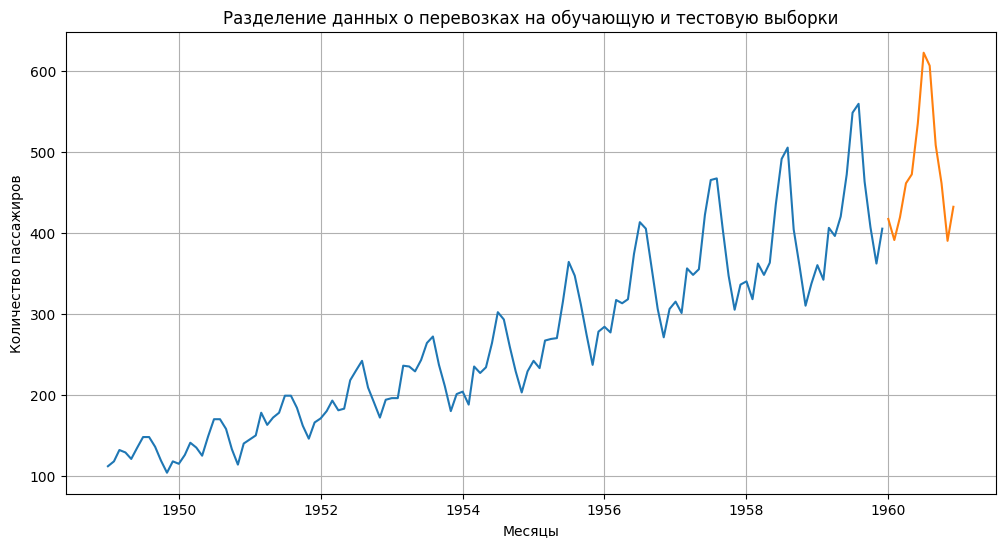

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data)
plt.plot(test_data)

plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

plt.grid()

plt.show()

#Time series analysis

##Проверка на стационарность

Для более точной оценки стационарности можно применить тест Дики-Фуллера.
Основная идея теста заключается в подтверждении или отклонении двух гипотез:


*   Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный
*   Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным.

Для подтверждения или опровержения этих гипотез используются p -values значения.

`p-values` — это наименьшее значение уровня значимости (то есть вероятности отказа от справедливой гипотезы).

В случае если `p–values` меньше значения 5%, то мы отвергаем нулевую гипотезу, и, следовательно, ряд является стационарным, имеет определенную периодичность, которую возможно выявить.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(passengers['#Passengers'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


`p-value` для данных о перевозках существенно выше 0,05. Мы не можем отвергнуть нулевую гипотезу. Процесс нестанионарный.

##ACF

Автокорреляция позволяет выявлять тренд и сезонность, а также используется при подборе параметров моделей.

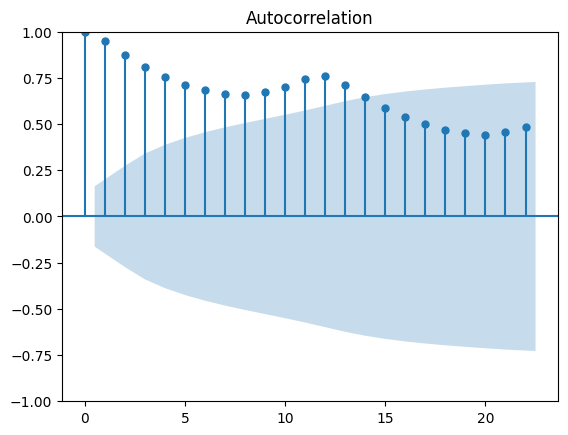

In [ ]:
plot_acf(passengers)
plt.show()

Видим, что лаг 12 сильнее коррелирует с исходным рядом, чем соседние лаги 10 и 11. То же самое можно сказать и про лаг 24. Такая автокорреляция позволяет предположить наличие (ежегодных) *сезонных колебаний*.

То, что корреляция постоянно положительная говорит о наличии *тренда*.

Синяя граница позволяет оценить статистическую значимость корреляции.

##PACF

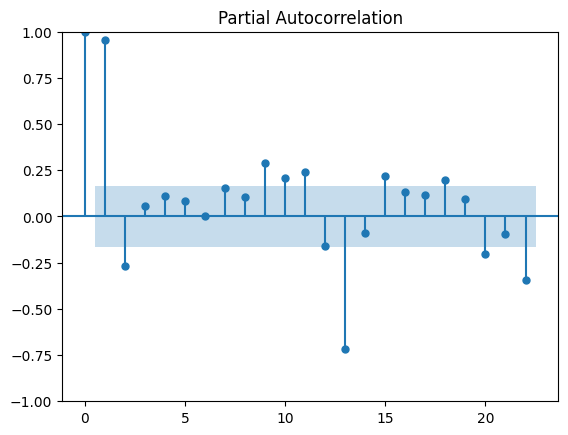

In [ ]:
plot_pacf(passengers)
plt.show()

#ARIMA model

In [ ]:
model = auto_arima(train_data, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=907.364, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.33 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.65 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.18 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.46 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   :

In [ ]:
# Forecast
prediction = model.predict(n_periods=len(test_data))

prediction

1960-01-01    419.967172
1960-02-01    399.849851
1960-03-01    457.994382
1960-04-01    444.474156
1960-05-01    464.789179
1960-06-01    514.125441
1960-07-01    587.804170
1960-08-01    597.010823
1960-09-01    499.531269
1960-10-01    442.359679
1960-11-01    396.410217
1960-12-01    438.651595
Freq: MS, dtype: float64

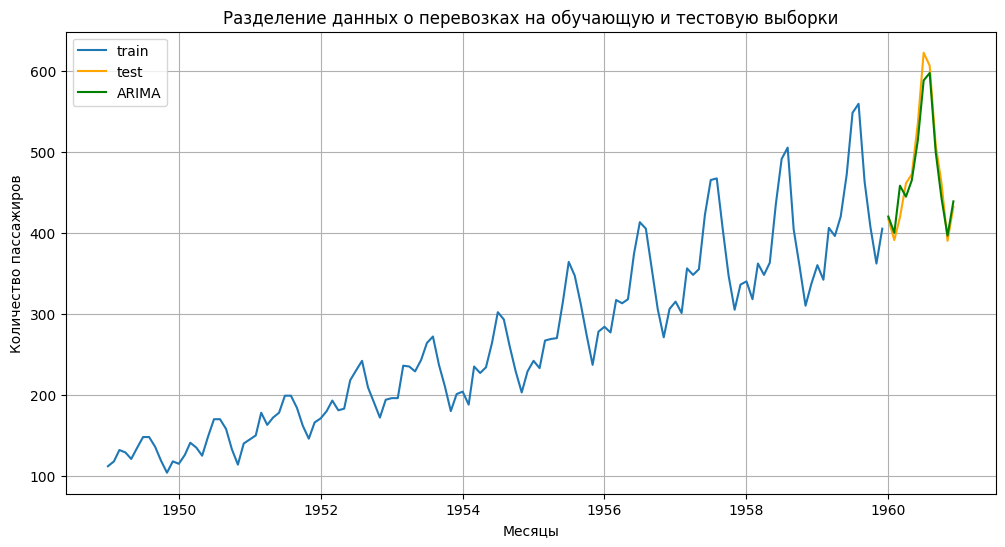

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label = 'train')
plt.plot(test_data, color = 'orange', label = 'test')
plt.plot(prediction, color = 'green', label = 'ARIMA')

plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

plt.grid()

plt.legend()

plt.show()

In [ ]:
print(f'MAE: {mean_absolute_error(test_data, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_data, prediction))}')

MAE: 14.898208317448123
RMSE: 18.536468798006823


#ETS model

In [ ]:
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)

In [ ]:
result = model.fit()

In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train_data)

# и закончится в конце тестового
end = len(train_data) + len(test_data) - 1

# применим метод predict
prediction = result.predict(start, end)
prediction

1960-01-01    415.454504
1960-02-01    397.087978
1960-03-01    457.470087
1960-04-01    445.367944
1960-05-01    466.186561
1960-06-01    520.730604
1960-07-01    592.422802
1960-08-01    598.842971
1960-09-01    498.828449
1960-10-01    442.382473
1960-11-01    396.515020
1960-12-01    424.291227
Freq: MS, dtype: float64

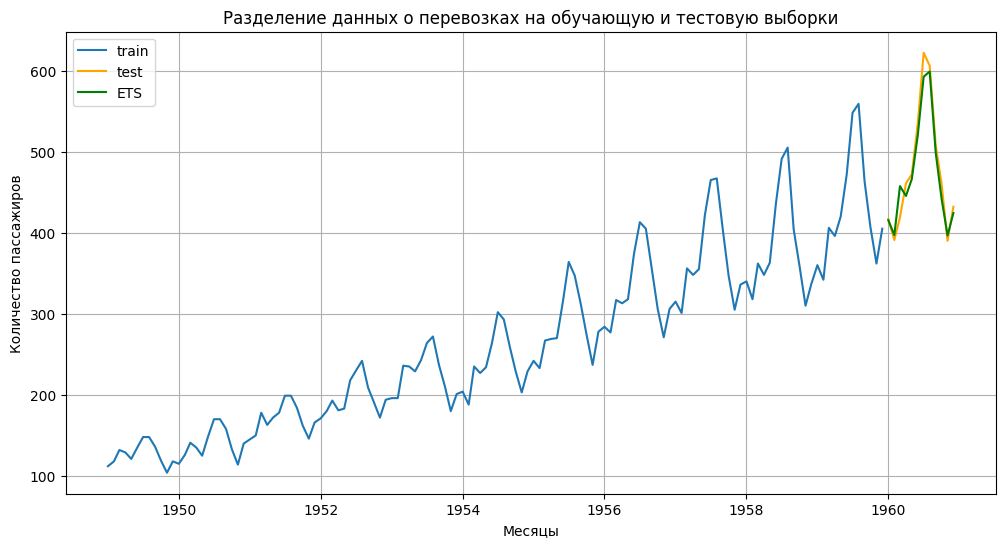

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label = 'train')
plt.plot(test_data, color = 'orange', label = 'test')
plt.plot(prediction, color = 'green', label = 'ETS')

plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

plt.grid()

plt.legend()

plt.show()

In [ ]:
print(f'MAE: {mean_absolute_error(test_data, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_data, prediction))}')

MAE: 13.380462475074248
RMSE: 16.979906128442913


#Data preporation

Методы обработки временных рядов:
1. Метод скользящего окна
2. Заполнение пропущенных значений
3. Удаление сезонности
4. Масштабирование (нормализация)

In [ ]:
scalar = MinMaxScaler(feature_range=(0,1))
df = scalar.fit_transform(np.array(passengers))

In [ ]:
seq_length = 50
x, y = sliding_windows(df, seq_length)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, shuffle=False)
x_train = torch.Tensor(x_train)
x_val = torch.Tensor(x_val)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, '\n')
print(y_batch.shape, '\n')

torch.Size([16, 50, 1]) 

torch.Size([16, 1]) 



#LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

##without deseasoning

Epoch: 0, loss: 0.01946
Epoch: 50, loss: 0.00662
Epoch: 100, loss: 0.00649


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

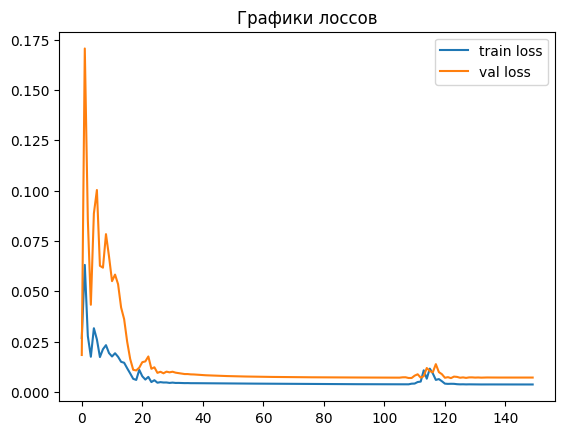

In [ ]:
num_epochs = 150
learning_rate = 1e-1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
train(lstm, loss_fn, optimizer, num_epochs, train_loader, val_loader)
prediction = predict(lstm, val_loader)
print('\n')
print_metrics(y_val, prediction)

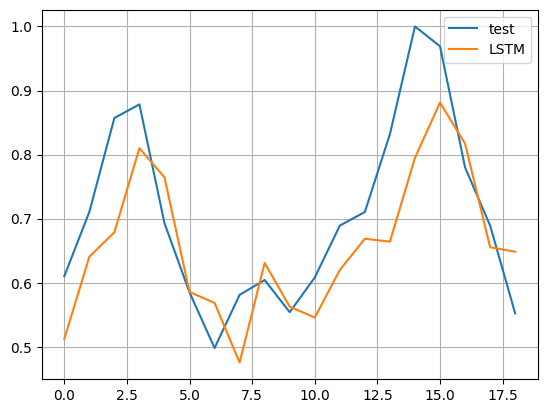

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'LSTM')
plt.grid()
plt.legend()

##with deseasoning

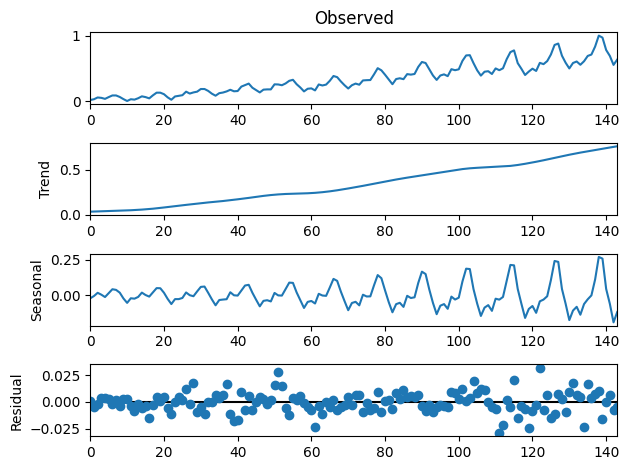

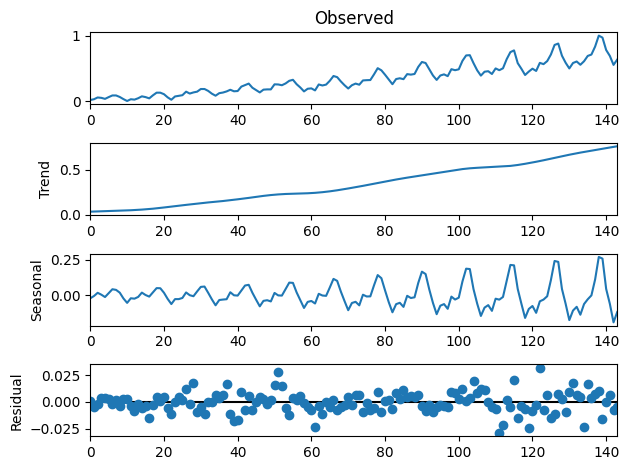

In [ ]:
res = STL(df, period = 12).fit()
res.plot()

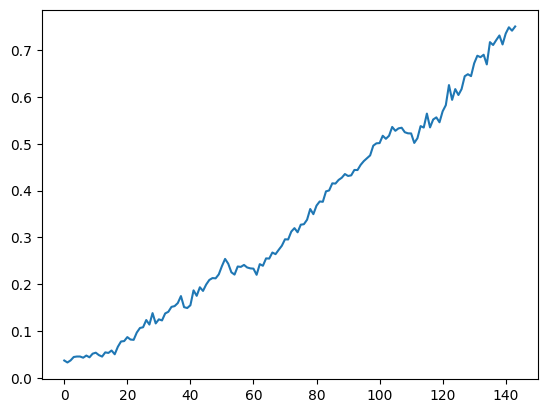

In [ ]:
trend = res.trend
seasonal = res.seasonal
residual = res.resid
deseasoned = trend + residual
plt.plot(deseasoned)

In [ ]:
deseasoned = deseasoned[:, np.newaxis]

In [ ]:
df_ = deseasoned

seq_length = 50
x_, y_ = sliding_windows(df_, seq_length)

In [ ]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(x_, y_, test_size = 0.2, shuffle=False)
x_train_ = torch.Tensor(x_train_)
x_val_ = torch.Tensor(x_val_)
y_train_ = torch.Tensor(y_train_)
y_val_ = torch.Tensor(y_val_)

In [ ]:
train_dataset_ = TensorDataset(x_train_, y_train_)
val_dataset_ = TensorDataset(x_val_, y_val_)
batch_size = 16
train_loader_ = DataLoader(train_dataset_, batch_size=batch_size, shuffle=False)
val_loader_ = DataLoader(val_dataset_, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader_))
print(x_batch.shape, '\n')
print(y_batch.shape, '\n')

torch.Size([16, 50, 1]) 

torch.Size([16, 1]) 



Epoch: 0, loss: 0.03222
Epoch: 50, loss: 0.00039


MAE: 0.09973770380020142
RMSE: 0.13527344167232513


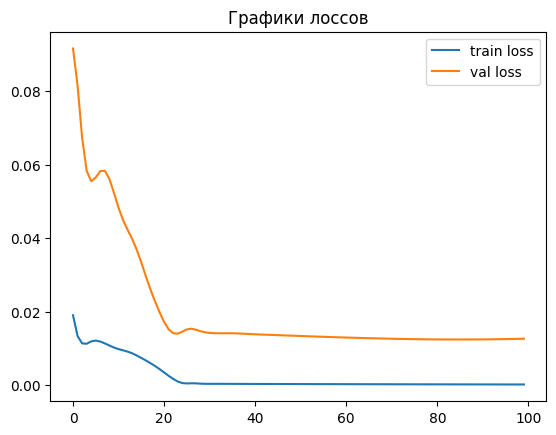

In [ ]:
num_epochs = 100
learning_rate = 1e-2

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
train(lstm, loss_fn, optimizer, num_epochs, train_loader_, val_loader_)
prediction = predict(lstm, val_loader) # прогнозируем на данных с имеющейся сезонностью
print('\n')
print_metrics(y_val, prediction)

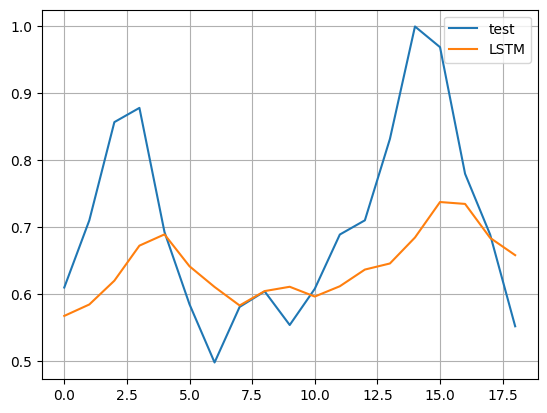

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'LSTM')
plt.grid()
plt.legend()

#RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, _ = self.rnn(x, h0)
        # out: batch_size, seq_length, hidden_size
        out = out[:, -1, :]
        out = self.fc(out)

        return out

##without deseasoning

Epoch: 0, loss: 0.02686
Epoch: 50, loss: 0.00793


MAE: 0.09066528081893921
RMSE: 0.11064402759075165


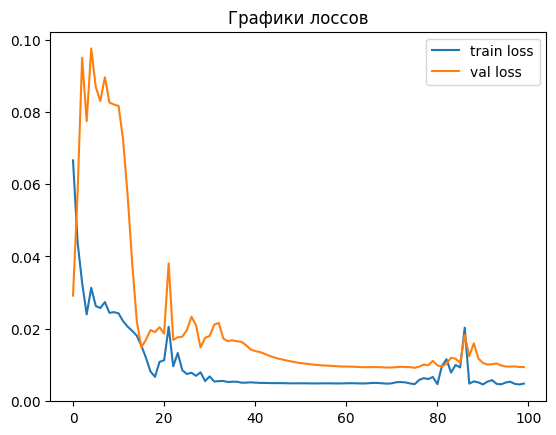

In [ ]:
num_epochs = 100
learning_rate = 1e-1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

rnn = RNN(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
train(rnn, loss_fn, optimizer, num_epochs, train_loader, val_loader)
prediction = predict(rnn, val_loader)
print('\n')
print_metrics(y_val, prediction)

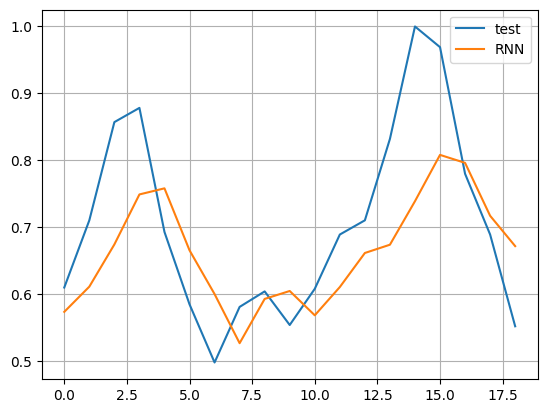

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'RNN')
plt.grid()
plt.legend()

##with deseasoning

Epoch: 0, loss: 0.00129
Epoch: 50, loss: 0.00049


MAE: 0.0847269594669342
RMSE: 0.09741995483636856


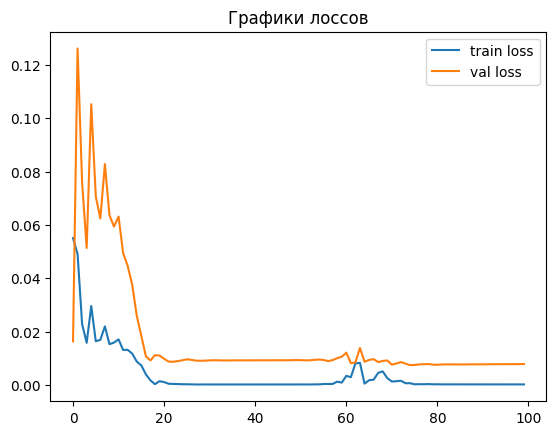

In [ ]:
num_epochs = 100
learning_rate = 1e-1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

rnn = RNN(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
train(rnn, loss_fn, optimizer, num_epochs, train_loader_, val_loader_)
prediction = predict(rnn, val_loader) # прогнозируем на данных с имеющейся сезонностью
print('\n')
print_metrics(y_val, prediction)

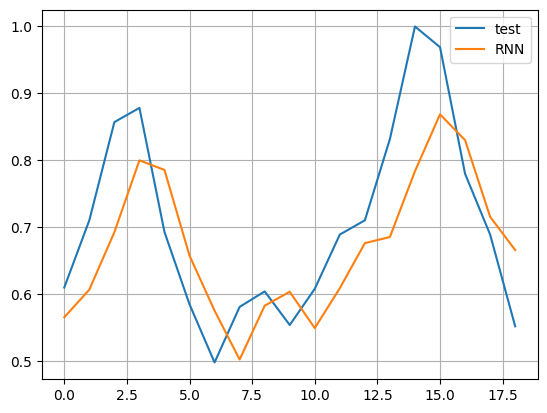

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'RNN')
plt.grid()
plt.legend()

#GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, _ = self.gru(x, h0)
        # out: batch_size, seq_length, hidden_size
        out = out[:, -1, :]
        out = self.fc(out)

        return out

##without deseasoning

Epoch: 0, loss: 0.02848
Epoch: 50, loss: 0.00663


MAE: 0.0795876681804657
RMSE: 0.09701139479875565


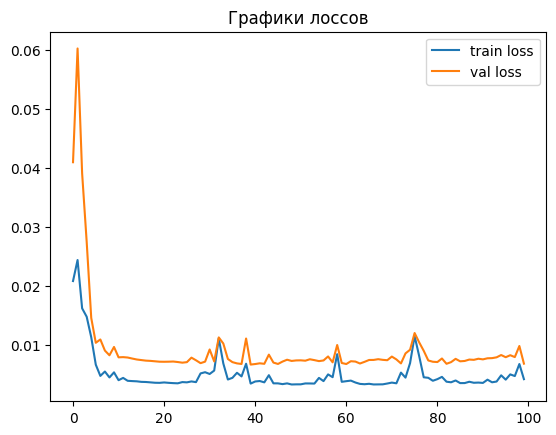

In [ ]:
num_epochs = 100
learning_rate = 1e-1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
train(gru, loss_fn, optimizer, num_epochs, train_loader, val_loader)
prediction = predict(gru, val_loader)
print('\n')
print_metrics(y_val, prediction)

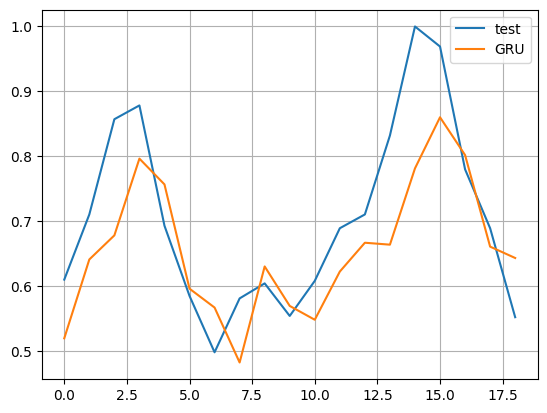

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'GRU')
plt.grid()
plt.legend()

##with deseasoning

Epoch: 0, loss: 0.00319
Epoch: 50, loss: 0.00041


MAE: 0.10960612446069717
RMSE: 0.12811417877674103


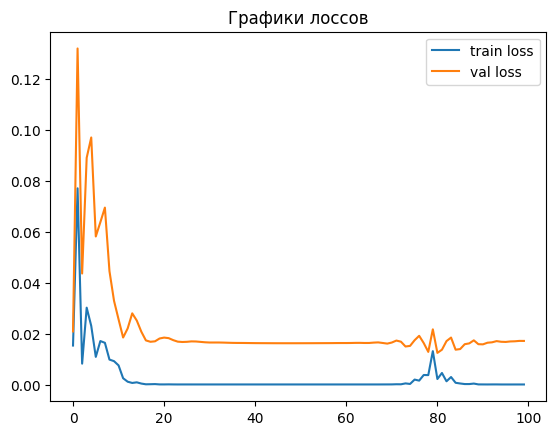

In [ ]:
num_epochs = 100
learning_rate = 1e-1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
train(gru, loss_fn, optimizer, num_epochs, train_loader_, val_loader_)
prediction = predict(gru, val_loader)
print('\n')
print_metrics(y_val, prediction)

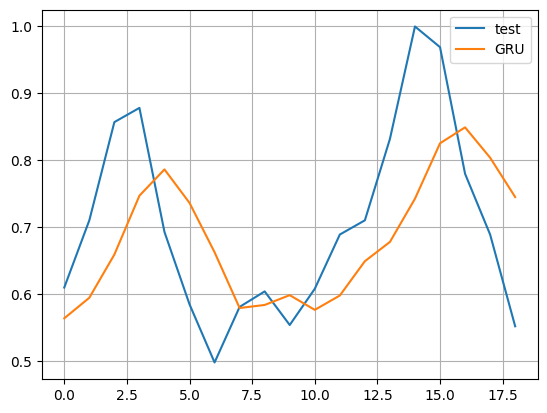

In [ ]:
plt.plot(y_val, label = 'test')
plt.plot(prediction, label = 'GRU')
plt.grid()
plt.legend()

without deseas
 0.07892, 0.09065, 0.07958 - LSTM, RNN, GRU

([<matplotlib.axis.XTick at 0x7fbd15edf400>,
 [Text(0, 0, 'LSTM'), Text(1, 0, 'RNN'), Text(2, 0, 'GRU')])

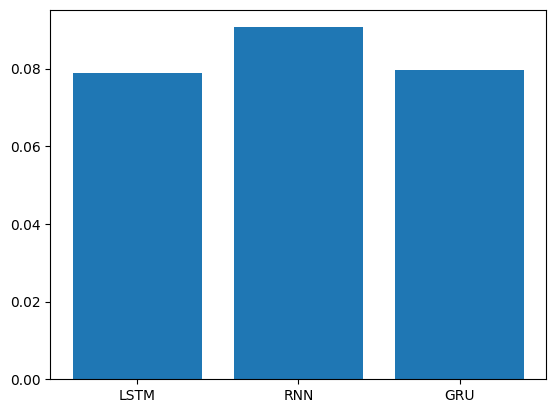

In [ ]:
yt = np.array([0.07892, 0.09065, 0.07958])
xt = [r for r in range(len(yt))]
xlabels =  ['LSTM', 'RNN', 'GRU']
plt.bar(xt, yt)
plt.xticks(xt, xlabels[: len(yt)])

with deseas

([<matplotlib.axis.XTick at 0x7fbd15f4bb50>,
 [Text(0, 0, 'LSTM'), Text(1, 0, 'RNN'), Text(2, 0, 'GRU')])

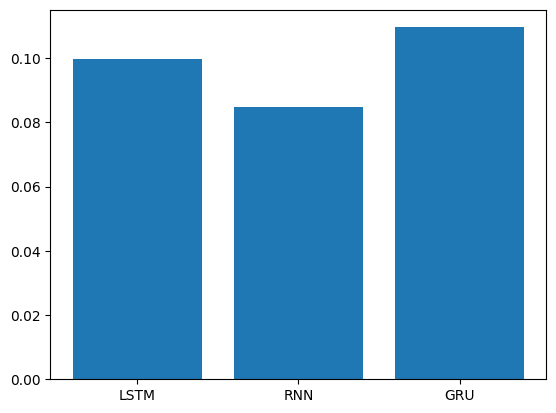

In [ ]:
yt = np.array([0.09973, 0.08472, 0.10960])
xt = [r for r in range(len(yt))]
xlabels =  ['LSTM', 'RNN', 'GRU']
plt.bar(xt, yt)
plt.xticks(xt, xlabels[: len(yt)])